In [1]:
import glob
from io import open
import pandas as pd
from pandas import DataFrame as df
from os import path
import re
import gensim
import numpy as np
from collections import Counter

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import nltk

In [4]:
from nltk import word_tokenize

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
from tools import get_psycinfo_database

In [7]:
words_df = get_psycinfo_database()

In [8]:
words_df.head()

,Abstract,Accession Number,Author(s),Type of Book,PsycINFO Classification Code,Conference,Document Type,Grant/Sponsorship,Key Concepts,Institution,...,Population Group,Publication Status,Publication Type,Publisher,Cited References,Title,Tests & Measures,Volume,Date,Term
0,The examination of an Afro-Brazilian martial a...,Peer Reviewed Journal: 2008-17783-005.,"Joseph, Janelle",NaN,Sports [3720].,NaN,Journal Article,NaN,"cultural commodity, authenticity, Afro-Brazili...","Joseph, Janelle: University of Toronto, Toront...",...,Human. Male. Female. Adulthood (18 yrs & older),NaN,Journal\n\nPeer Reviewed Journal,Human Kinetics; US,"Assuncao, M. R. (2005). Capoeira: The history ...",The logical paradox of the cultural commodity:...,NaN,25,2008,multiculturalism
1,"Reviews the book, Multicultural understanding ...",Peer Reviewed Journal: 2008-17535-024.,"Kim, Sun",NaN,Psychological Disorders [3210].,NaN,Review-Book,NaN,"multiculturalism, child psychopathology, adole...","Kim, Sun: Department of Psychiatry, University...",...,Human. Childhood (birth-12 yrs). Adolescence ...,NaN,Journal\n\nPeer Reviewed Journal,American Psychiatric Assn; US,"Hermans, H. J. M., & Kempen, H. J. G. (1999). ...",Review of Multicultural understanding of child...,NaN,59,2008,multiculturalism
2,(create) This chapter considers the impact of ...,Book: 2008-17305-010.,"Dana, Richard H\n\nAllen, James",NaN,Social Processes & Social Issues [2900].,NaN,Chapter,NaN,"globalization, psychological science, resident...","Dana, Richard H.: Portland State University, R...",...,Human,NaN,Book\n\nEdited Book,Springer Science + Business Media; US,NaN,Globalization: Psychological problems and soci...,NaN,NaN,2008,multiculturalism
3,(create) This chapter selects and distills the...,Book: 2008-17305-009.,"Dana, Richard H",NaN,Professional Education & Training [3410].,NaN,Chapter,NaN,"cultural competency training model, at risk mu...","Dana, Richard H.: Portland State University, R...",...,Human,NaN,Book\n\nEdited Book,Springer Science + Business Media; US,NaN,A cultural competency training model.,NaN,NaN,2008,multiculturalism
4,(from the preface) Approaches cultural compete...,Book: 2008-17305-008.,"Rogers, Margaret R",NaN,Professional Education & Training [3410].,NaN,Chapter,NaN,"cultural competency education, clinical & coun...","Rogers, Margaret R.: Psychology Department, Un...",...,Human,NaN,Book\n\nEdited Book,Springer Science + Business Media; US,NaN,Cultural competency training in professional p...,NaN,NaN,2008,multiculturalism


## Generate Corpora

In [9]:
words_to_replace = {"/":"-", "bi-ethnic": "biethnic", "bi-racial": "biracial", 
                    "mono-ethnic": "monoethnic", "poly-ethnic": "polyethnic", 
                    "mono-racial": "monoracial", "multi-racial": "multiracial",
                    "inter-racial": "interracial", "mono-cultural": "monocultural",
                    "bi-cultural": "bicultural", "multi-cultural": "multicultural",
                    "other ethnicity":"other-ethnicity", "other race": "other-race", 
                    "mixed race": "mixed-race", "mixed ethnicity": "mixed-ethnicity"}

In [10]:
def FixText(text):
    for old, new in words_to_replace.items():
        text = text.replace(old, new)
    return text

In [11]:
abstracts = [FixText(x.lower()) for x in words_df.Abstract.fillna("").values]

In [12]:
abstract_text = [word_tokenize(x) for x in abstracts]

In [13]:
abstract_text[0][:10]

['the',
 'examination',
 'of',
 'an',
 'afro-brazilian',
 'martial',
 'art',
 ',',
 'capoeira',
 ',']

In [14]:
print("Number of Abstracts", len(abstract_text))
print("Number of words", sum(len(x) for x in abstract_text))

Number of Abstracts 28305
Number of words 5982943


In [15]:
model = gensim.models.Word2Vec(sentences=abstract_text, size=16, window=5, min_count=2, sample=0,
                               workers=10, hs=1, sg=1, cbow_mean=0)

In [104]:
model.save("data/PsycInfo/processed/abstract_model.pkl")

In [105]:
ls -lh data/PsycInfo/processed/abstract_model.pkl

-rw-rw-r-- 1 rmyeid rmyeid 24M Mar 27 19:57 data/PsycInfo/processed/abstract_model.pkl


In [112]:
model = model.load("data/PsycInfo/processed/abstract_model.pkl")

In [16]:
len(model.vocab.keys())

43460

In [18]:
model.most_similar_cosmul("multicultural")

[('counseling', 0.9698255062103271),
 ('counsellor', 0.9680532813072205),
 ('counselling', 0.9673334360122681),
 ('professional', 0.96677166223526),
 ('advocacy', 0.9642621874809265),
 ('science', 0.9636713266372681),
 ('sport', 0.9636472463607788),
 ('psychology', 0.9631773829460144),
 ('cross-cultural', 0.9626858234405518),
 ('globalization-cultural', 0.9619668126106262)]

In [19]:
model.most_similar_cosmul("biracial")

[('multiracial', 0.9672592282295227),
 ('asian-white', 0.9613644480705261),
 ('ancestry', 0.9550033807754517),
 ('monoracial', 0.9530125260353088),
 ('inauthenticity', 0.9526103138923645),
 ('black-white', 0.9484965205192566),
 ('nonwhite', 0.9474827647209167),
 ('ethnic-racial', 0.9473452568054199),
 ('h3', 0.945253312587738),
 ('biethnic', 0.9410421252250671)]

In [20]:
model.most_similar_cosmul("monoracial")

[('nonwhite', 0.9694812297821045),
 ('inauthenticity', 0.9690624475479126),
 ('asian-white', 0.9675005078315735),
 ('black-white', 0.9654460549354553),
 ('counterparts', 0.9648268818855286),
 ('tg', 0.9640914797782898),
 ('monoculturals', 0.9639790654182434),
 ('ancestry', 0.9626777768135071),
 ('asian-australian', 0.9614773392677307),
 ('monoethnic', 0.9604117274284363)]

In [135]:
model.most_similar("bicultural", topn=10)

[('ethnic-racial', 0.9406040906906128),
 ('group', 0.927253246307373),
 ('monocultural', 0.9029431343078613),
 ('self-identity', 0.9024025201797485),
 ('matching', 0.8927230834960938),
 ('ethnocultural', 0.8855383396148682),
 ('supervisor-white', 0.8744437098503113),
 ('identity', 0.8736236691474915),
 ('self-schema', 0.8724583983421326),
 ('tricultural', 0.8712344765663147)]

## Hierchical Clustering

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette

In [23]:
words = ['monocultural', 'monoracial', 'bicultural', 'biracial', 'biethnic', 'interracial',
        'multicultural', 'multiracial', 'multiethnic', 'polycultural', 'polyracial', 'polyethnic',
        'mixed race', 'mixed ethnicity', 'other race', 'other ethnicity', 'multiculturalism', 'polyculturalism',
         'cultural pluralism']

In [24]:
expansion = []
for w in words:
    if w in model:
        expansion.extend([x for x,y in model.most_similar(w, topn=50)])
counter = Counter(expansion)
expansion = [x for x, y in counter.items() if y > 2]

In [137]:
y = []
X = []
normalized = True
for w in set(words + expansion):
    if w in model:
        v = model.syn0norm[model.vocab[w].index, :] if normalized else model[w]
        X.append(v)
        y.append(w)
X = np.asarray(X)
X = (X.T / np.linalg.norm(X, axis=1)).T

In [138]:
X.shape

(28, 16)

In [139]:
print(plt.style.available)

['fivethirtyeight', 'seaborn-pastel', 'grayscale', 'seaborn-colorblind', 'ggplot', 'seaborn-notebook', 'seaborn-dark-palette', 'dark_background', 'seaborn-whitegrid', 'seaborn-bright', 'bmh', 'seaborn-dark', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-ticks', 'seaborn-muted', 'seaborn-talk', 'seaborn-deep', 'seaborn-paper', 'classic', 'seaborn-white']


In [92]:
set_link_color_palette([str(x) for x in [0.3, 0.5, 0.75]])

In [180]:
plt.style.use('seaborn-ticks')

In [181]:
Z = linkage(X, 'ward')

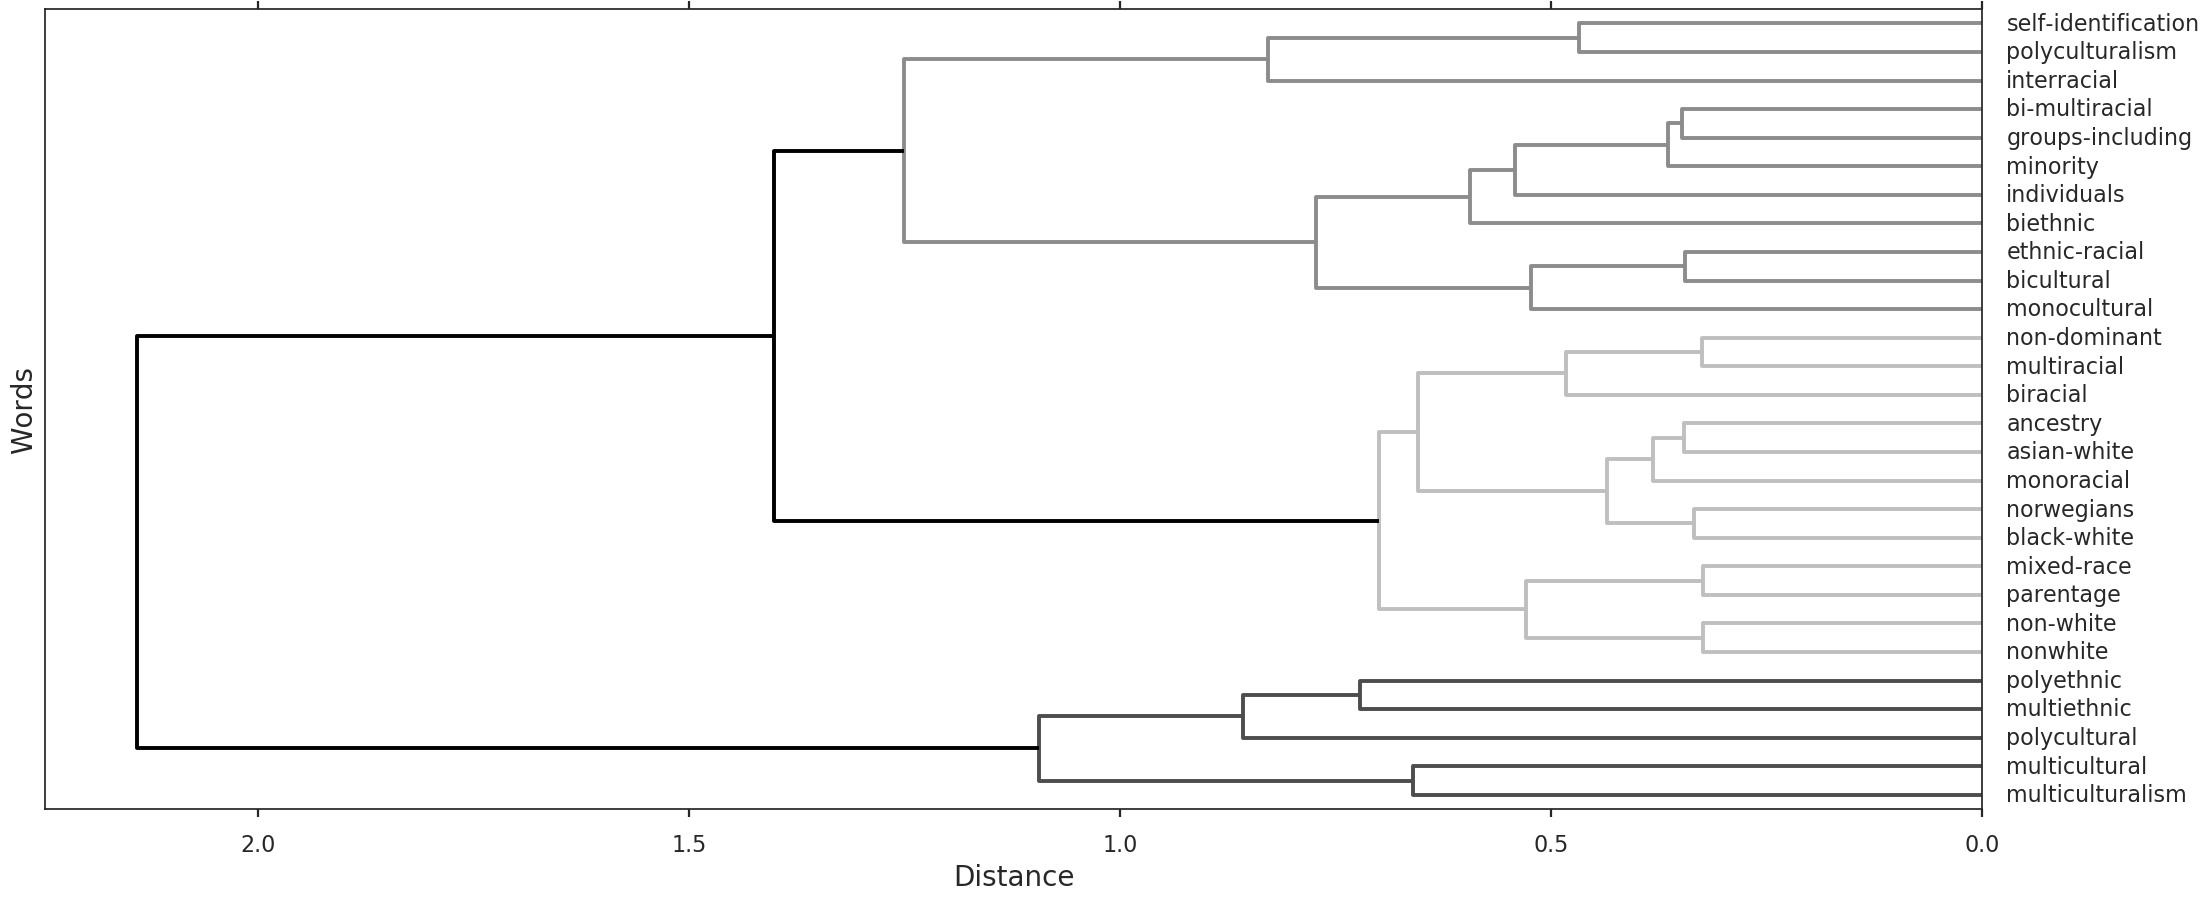

In [186]:
plt.figure(figsize=(25, 10))
plt.ylabel('Words', family = "Times New Roman", fontsize=20)
plt.xlabel('Distance', family = "Times New Roman", fontsize=20)
plt.grid(False)
_ = dendrogram(Z, orientation="left", above_threshold_color='k', color_threshold=1.4, labels=y,
               leaf_rotation=0., leaf_font_size=16.)